# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import plotly.graph_objs as go
import plotly.graph_objs as go
import plotly.offline as pyoff
from tools import *

pyoff.init_notebook_mode(connected=True)

In [2]:
# TRAINING PARAMETERS

size=128 #Image size
BS = 64
NB_EPOCHS = 10
MAX_LR = 1e-4

HIST = False

# DATA PREPARATION
path = untar_data(URLs.IMAGENETTE_160)
tfms = get_transforms(do_flip=False)
data = ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(tfms, size=size).databunch(bs=BS).presize(size, scale=(0.35,1)).normalize(imagenet_stats)

# OTHERS
append_stats = partial(append_stats_n, HIST)
recorder = RecordExp()
activations_prestats=[]

In [3]:
data.batch_stats()

[tensor([-0.1081, -0.0004,  0.1144]), tensor([1.2456, 1.2416, 1.3043])]

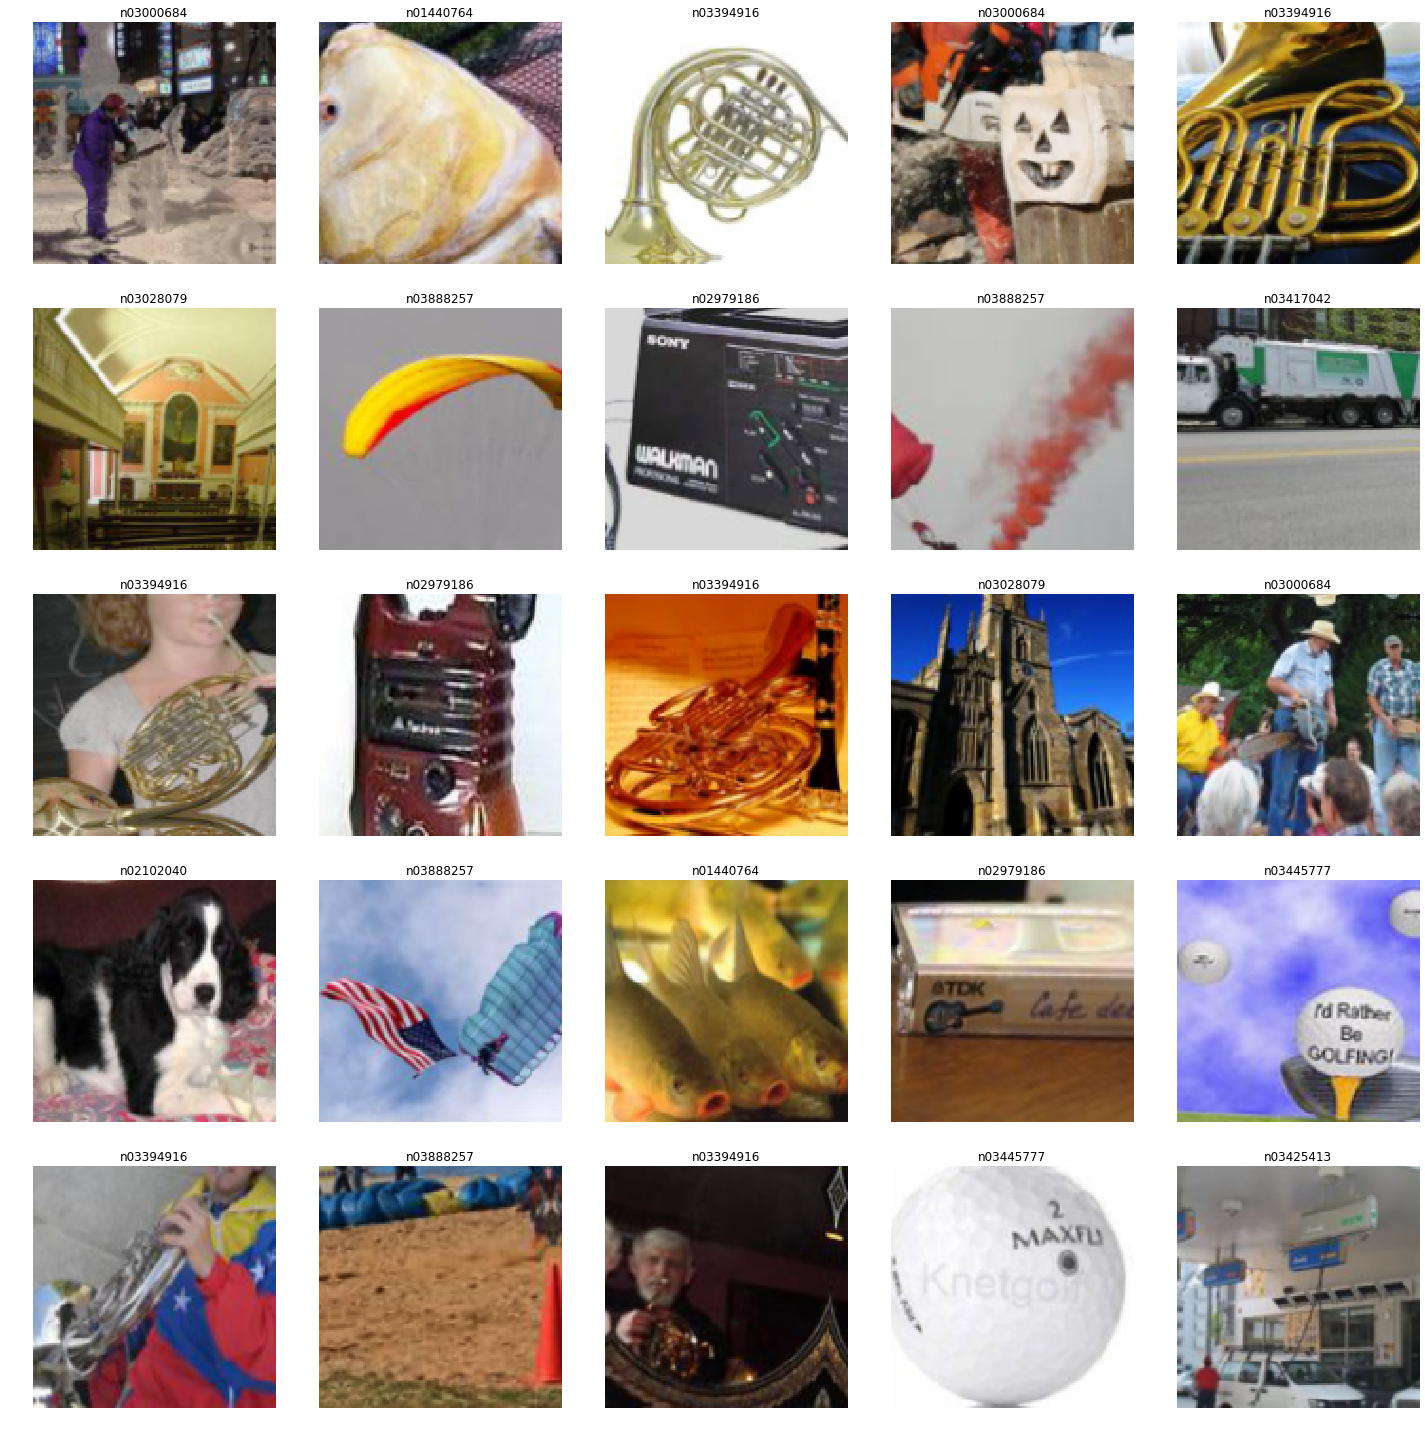

In [4]:
data.show_batch()

# Model building

In [9]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak != 0 else F.relu(x)
        if self.sub != 0: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=1, zero_bn=False, act=True, bias=False, **kwargs):
        super().__init__()
        self.bn = nn.BatchNorm2d(nf)
        nn.init.constant_(self.bn.weight, 0. if zero_bn else 1.)
        self.conv = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)
        if act: 
            self.relu = GeneralRelu(**kwargs)
            
        self.act = act
    
    def forward(self, x):
        out = self.conv(x)
        if self.act: out = self.relu(out)
        return out
    
    def has_relu(self):
        return self.act
    
    @property
    def bias(self):
        return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight
    
 
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)


class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1, **kwargs):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [ConvLayer(ni, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 3, zero_bn=True, act=False, **kwargs)
        ] if expansion == 1 else [
                   ConvLayer(ni, nh, 1, **kwargs),
                   ConvLayer(nh, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 1, zero_bn=True, act=False, **kwargs)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act=False, **kwargs)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act_fn = GeneralRelu(**kwargs)

    def forward(self, x): 

        return self.act_fn(self.convs(x) + self.idconv(self.pool(x)))
    
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=10, **kwargs):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [ConvLayer(nfs[i], nfs[i+1], stride=2 if i==0 else 1, **kwargs)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, **kwargs)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        #init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, **kwargs):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, **kwargs)
              for i in range(n_blocks)])  
    
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

In [10]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [11]:
model = xresnet50(c_out=data.c)

In [12]:
def get_first_model():
    model = xresnet50(c_out=data.c)
    learn = Learner(data, model, metrics=[accuracy])
    
    return model, learn

# Pytorch default init

In [13]:
model, learn = get_first_model()


In [14]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         864        True      
______________________________________________________________________
GeneralRelu          [32, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         18,432     True      
______________________________________________________________________
GeneralRelu          [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
GeneralRelu          [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________

In [15]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.2139)] / [tensor(0.3946)]

ConvLayer: 
[tensor(0.0804)] / [tensor(0.1414)]

ConvLayer: 
[tensor(0.0334)] / [tensor(0.0544)]

ConvLayer: 
[tensor(0.0156)] / [tensor(0.0290)]

ConvLayer: 
[tensor(0.0075)] / [tensor(0.0114)]

ConvLayer: 
[tensor(-0.0002)] / [tensor(0.0078)]

ConvLayer: 
[tensor(-0.0022)] / [tensor(0.0503)]

ConvLayer: 
[tensor(0.0069)] / [tensor(0.0121)]

ConvLayer: 
[tensor(0.0032)] / [tensor(0.0047)]

ConvLayer: 
[tensor(-0.0002)] / [tensor(0.0032)]

ConvLayer: 
[tensor(0.0071)] / [tensor(0.0113)]

ConvLayer: 
[tensor(0.0029)] / [tensor(0.0047)]

ConvLayer: 
[tensor(-3.9017e-05)] / [tensor(0.0032)]

ConvLayer: 
[tensor(0.0077)] / [tensor(0.0118)]

ConvLayer: 
[tensor(0.0032)] / [tensor(0.0050)]

ConvLayer: 
[tensor(-2.7087e-05)] / [tensor(0.0035)]

ConvLayer: 
[tensor(-0.0005)] / [tensor(0.0188)]

ConvLayer: 
[tensor(0.0026)] / [tensor(0.0044)]

ConvLayer: 
[tensor(0.0011)] / [tensor(0.0016)]

ConvLayer: 
[tensor(2.4878e-05)] / [tensor(0.0012)]

Co

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


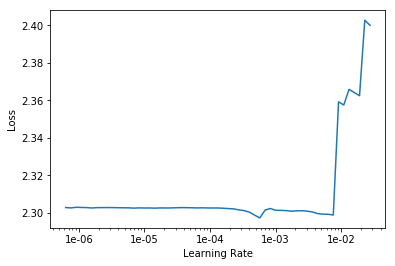

In [16]:
model, learn = get_first_model()

learn.lr_find()
learn.recorder.plot()

In [17]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,2.226288,2.119808,0.190000,00:23
1,2.108911,1.982529,0.266000,00:23
2,2.006648,1.834358,0.358000,00:23
3,1.867608,1.764202,0.370000,00:23
4,1.748564,1.572130,0.460000,00:23
5,1.634976,1.532320,0.478000,00:23
6,1.564649,1.465930,0.508000,00:23
7,1.502522,1.394710,0.544000,00:23
8,1.456754,1.422002,0.544000,00:23
9,1.464871,1.358514,0.568000,00:23


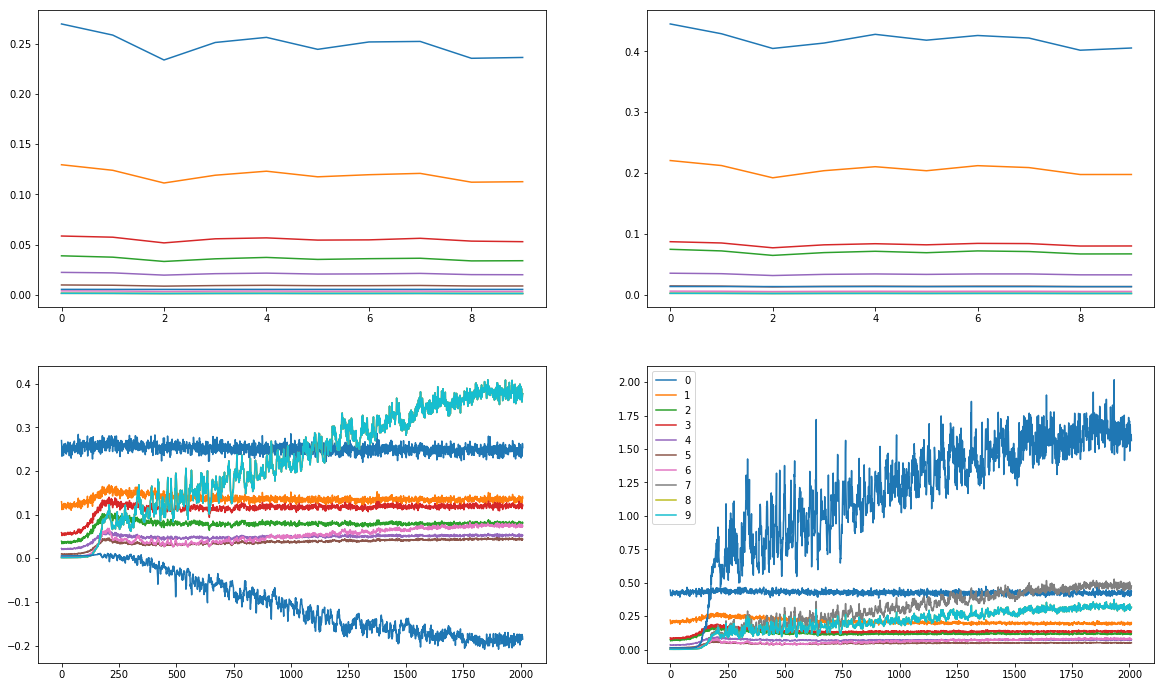

In [18]:
recorder.add_exp(learn.recorder, "pytorch default")
viz(hooks)

In [19]:
if HIST:
    stats_ratio_zeros(hooks)

# Kaiming Init

In [20]:
model, learn = get_first_model()
get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2645)] / [tensor(0.4529)]

ConvLayer: 
[tensor(0.1181)] / [tensor(0.1727)]

ConvLayer: 
[tensor(0.0378)] / [tensor(0.0666)]

ConvLayer: 
[tensor(0.0248)] / [tensor(0.0368)]

ConvLayer: 
[tensor(0.0092)] / [tensor(0.0154)]

ConvLayer: 
[tensor(-1.5462e-05)] / [tensor(0.0104)]

ConvLayer: 
[tensor(0.0002)] / [tensor(0.0606)]

ConvLayer: 
[tensor(0.0090)] / [tensor(0.0141)]

ConvLayer: 
[tensor(0.0036)] / [tensor(0.0060)]

ConvLayer: 
[tensor(0.0001)] / [tensor(0.0041)]

ConvLayer: 
[tensor(0.0122)] / [tensor(0.0170)]

ConvLayer: 
[tensor(0.0050)] / [tensor(0.0075)]

ConvLayer: 
[tensor(-0.0003)] / [tensor(0.0054)]

ConvLayer: 
[tensor(0.0109)] / [tensor(0.0169)]

ConvLayer: 
[tensor(0.0041)] / [tensor(0.0069)]

ConvLayer: 
[tensor(0.0001)] / [tensor(0.0046)]

ConvLayer: 
[tensor(-0.0006)] / [tensor(0.0252)]

ConvLayer: 
[tensor(0.0032)] / [tensor(0.0055)]

ConvLayer: 
[tensor(0.0015)] / [tensor(0.0021)]

ConvLayer: 
[tensor(-1.8168e-05)] / [tensor(0.0015)]

ConvLaye

[([tensor(0.2645)], [tensor(0.4529)]),
 ([tensor(0.1181)], [tensor(0.1727)]),
 ([tensor(0.0378)], [tensor(0.0666)]),
 ([tensor(0.0248)], [tensor(0.0368)]),
 ([tensor(0.0092)], [tensor(0.0154)]),
 ([tensor(-1.5462e-05)], [tensor(0.0104)]),
 ([tensor(0.0002)], [tensor(0.0606)]),
 ([tensor(0.0090)], [tensor(0.0141)]),
 ([tensor(0.0036)], [tensor(0.0060)]),
 ([tensor(0.0001)], [tensor(0.0041)]),
 ([tensor(0.0122)], [tensor(0.0170)]),
 ([tensor(0.0050)], [tensor(0.0075)]),
 ([tensor(-0.0003)], [tensor(0.0054)]),
 ([tensor(0.0109)], [tensor(0.0169)]),
 ([tensor(0.0041)], [tensor(0.0069)]),
 ([tensor(0.0001)], [tensor(0.0046)]),
 ([tensor(-0.0006)], [tensor(0.0252)]),
 ([tensor(0.0032)], [tensor(0.0055)]),
 ([tensor(0.0015)], [tensor(0.0021)]),
 ([tensor(-1.8168e-05)], [tensor(0.0015)]),
 ([tensor(0.0041)], [tensor(0.0064)]),
 ([tensor(0.0014)], [tensor(0.0023)]),
 ([tensor(4.5649e-05)], [tensor(0.0015)]),
 ([tensor(0.0039)], [tensor(0.0062)]),
 ([tensor(0.0016)], [tensor(0.0023)]),
 ([tensor

In [21]:
def init_cnn(m, leak=0):
    if not isinstance(m, ConvLayer) and getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight, a=leak)
    for l in m.children(): init_cnn(l)

In [22]:
init_cnn(model)

In [23]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.4967)] / [tensor(0.8408)]

ConvLayer: 
[tensor(0.5617)] / [tensor(0.9266)]

ConvLayer: 
[tensor(0.5841)] / [tensor(0.9535)]

ConvLayer: 
[tensor(0.6301)] / [tensor(0.9983)]

ConvLayer: 
[tensor(0.6351)] / [tensor(1.0031)]

ConvLayer: 
[tensor(-0.0171)] / [tensor(1.5829)]

ConvLayer: 
[tensor(-0.1138)] / [tensor(2.1234)]

ConvLayer: 
[tensor(0.8108)] / [tensor(1.4037)]

ConvLayer: 
[tensor(1.1480)] / [tensor(1.6613)]

ConvLayer: 
[tensor(0.3009)] / [tensor(2.7031)]

ConvLayer: 
[tensor(2.0111)] / [tensor(2.8853)]

ConvLayer: 
[tensor(2.6622)] / [tensor(3.5524)]

ConvLayer: 
[tensor(0.0452)] / [tensor(5.8361)]

ConvLayer: 
[tensor(2.9397)] / [tensor(4.8319)]

ConvLayer: 
[tensor(2.8799)] / [tensor(4.5065)]

ConvLayer: 
[tensor(-0.1966)] / [tensor(7.6701)]

ConvLayer: 
[tensor(0.0661)] / [tensor(8.2686)]

ConvLayer: 
[tensor(3.5849)] / [tensor(6.6346)]

ConvLayer: 
[tensor(4.2569)] / [tensor(6.2637)]

ConvLayer: 
[tensor(-0.3520)] / [tensor(10.4617)]

ConvLayer: 
[te

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


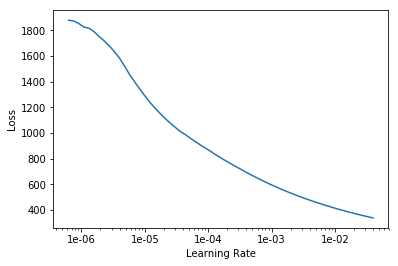

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,19.411219,12.682913,0.230000,00:23
1,4.843490,3.247048,0.318000,00:23
2,2.254540,2.052108,0.388000,00:23
3,1.903628,1.893777,0.406000,00:23
4,1.709110,1.562787,0.458000,00:23
5,1.571289,1.415470,0.562000,00:24
6,1.484459,1.425865,0.534000,00:24
7,1.319615,1.091571,0.642000,00:24
8,1.209636,1.110519,0.640000,00:24
9,1.149934,1.058369,0.660000,00:24


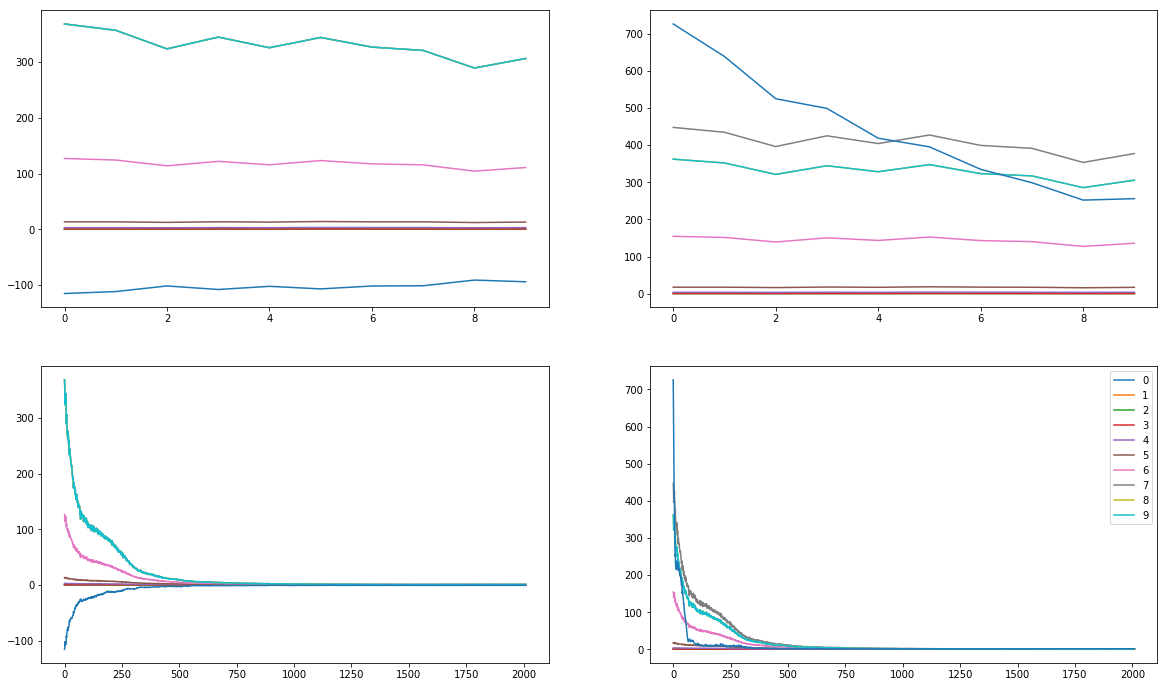

In [26]:
recorder.add_exp(learn.recorder, 'Kaiming init')
viz(hooks)

In [27]:
if HIST:
    stats_ratio_zeros(hooks)

# LSUV init

In [28]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [29]:
model, learn = get_first_model()
#layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.3129)] / [tensor(0.4504)]

ConvLayer: 
[tensor(0.1268)] / [tensor(0.1969)]

ConvLayer: 
[tensor(0.0471)] / [tensor(0.0781)]

ConvLayer: 
[tensor(0.0225)] / [tensor(0.0377)]

ConvLayer: 
[tensor(0.0110)] / [tensor(0.0157)]

ConvLayer: 
[tensor(0.0004)] / [tensor(0.0110)]

ConvLayer: 
[tensor(-0.0050)] / [tensor(0.0683)]

ConvLayer: 
[tensor(0.0113)] / [tensor(0.0177)]

ConvLayer: 
[tensor(0.0045)] / [tensor(0.0072)]

ConvLayer: 
[tensor(0.0002)] / [tensor(0.0048)]

ConvLayer: 
[tensor(0.0079)] / [tensor(0.0125)]

ConvLayer: 
[tensor(0.0030)] / [tensor(0.0046)]

ConvLayer: 
[tensor(-0.0004)] / [tensor(0.0033)]

ConvLayer: 
[tensor(0.0107)] / [tensor(0.0154)]

ConvLayer: 
[tensor(0.0041)] / [tensor(0.0066)]

ConvLayer: 
[tensor(0.0003)] / [tensor(0.0045)]

ConvLayer: 
[tensor(-0.0015)] / [tensor(0.0263)]

ConvLayer: 
[tensor(0.0037)] / [tensor(0.0059)]

ConvLayer: 
[tensor(0.0013)] / [tensor(0.0020)]

ConvLayer: 
[tensor(-4.5096e-05)] / [tensor(0.0014)]

ConvLayer: 


[([tensor(0.3129)], [tensor(0.4504)]),
 ([tensor(0.1268)], [tensor(0.1969)]),
 ([tensor(0.0471)], [tensor(0.0781)]),
 ([tensor(0.0225)], [tensor(0.0377)]),
 ([tensor(0.0110)], [tensor(0.0157)]),
 ([tensor(0.0004)], [tensor(0.0110)]),
 ([tensor(-0.0050)], [tensor(0.0683)]),
 ([tensor(0.0113)], [tensor(0.0177)]),
 ([tensor(0.0045)], [tensor(0.0072)]),
 ([tensor(0.0002)], [tensor(0.0048)]),
 ([tensor(0.0079)], [tensor(0.0125)]),
 ([tensor(0.0030)], [tensor(0.0046)]),
 ([tensor(-0.0004)], [tensor(0.0033)]),
 ([tensor(0.0107)], [tensor(0.0154)]),
 ([tensor(0.0041)], [tensor(0.0066)]),
 ([tensor(0.0003)], [tensor(0.0045)]),
 ([tensor(-0.0015)], [tensor(0.0263)]),
 ([tensor(0.0037)], [tensor(0.0059)]),
 ([tensor(0.0013)], [tensor(0.0020)]),
 ([tensor(-4.5096e-05)], [tensor(0.0014)]),
 ([tensor(0.0041)], [tensor(0.0069)]),
 ([tensor(0.0019)], [tensor(0.0028)]),
 ([tensor(-1.4120e-05)], [tensor(0.0020)]),
 ([tensor(0.0034)], [tensor(0.0055)]),
 ([tensor(0.0014)], [tensor(0.0022)]),
 ([tensor(9.

In [30]:
def is_conv_layer(l):
    mon_layers = (ConvLayer)
    if isinstance(l, ConvLayer) and not l.has_relu():
        return False
    
    return isinstance(l, mon_layers)

In [31]:

def lsuv_conv(m, xb, model, debug=False):
    h = Hook2(m, init_stats)
      

    
    while model(xb) is not None and abs(h.stats[0][-1])  > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the bias of module {str(h.mod)[:9]}, val before= {m.bias}')
        m.bias -= h.stats[0][-1]
        if debug: print(f'after = {m.bias}\n')
       
     
    while model(xb) is not None and abs(h.stats[1][-1]-1) > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the std of module {str(h.mod)[:9]}, val before= {h.stats[1][-1]}')
        m.weight.data /= h.stats[1][-1]
        if debug: print(f'after = {m.weight.data.std()}\n')
    h.remove()    
    return h.stats[0][-1], h.stats[1][-1]

In [32]:
xb = next(iter(data.train_dl))

In [33]:
model, learn = get_first_model()
layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2617)] / [tensor(0.4175)]

ConvLayer: 
[tensor(0.1361)] / [tensor(0.2016)]

ConvLayer: 
[tensor(0.0580)] / [tensor(0.0908)]

ConvLayer: 
[tensor(0.0294)] / [tensor(0.0495)]

ConvLayer: 
[tensor(0.0168)] / [tensor(0.0233)]

ConvLayer: 
[tensor(-0.0006)] / [tensor(0.0164)]

ConvLayer: 
[tensor(0.0025)] / [tensor(0.0800)]

ConvLayer: 
[tensor(0.0109)] / [tensor(0.0169)]

ConvLayer: 
[tensor(0.0049)] / [tensor(0.0077)]

ConvLayer: 
[tensor(-0.0001)] / [tensor(0.0057)]

ConvLayer: 
[tensor(0.0145)] / [tensor(0.0218)]

ConvLayer: 
[tensor(0.0074)] / [tensor(0.0104)]

ConvLayer: 
[tensor(-0.0002)] / [tensor(0.0075)]

ConvLayer: 
[tensor(0.0131)] / [tensor(0.0211)]

ConvLayer: 
[tensor(0.0066)] / [tensor(0.0096)]

ConvLayer: 
[tensor(9.2679e-05)] / [tensor(0.0070)]

ConvLayer: 
[tensor(-0.0007)] / [tensor(0.0318)]

ConvLayer: 
[tensor(0.0059)] / [tensor(0.0092)]

ConvLayer: 
[tensor(0.0024)] / [tensor(0.0037)]

ConvLayer: 
[tensor(-1.7815e-05)] / [tensor(0.0026)]

ConvLay

[([tensor(0.2617)], [tensor(0.4175)]),
 ([tensor(0.1361)], [tensor(0.2016)]),
 ([tensor(0.0580)], [tensor(0.0908)]),
 ([tensor(0.0294)], [tensor(0.0495)]),
 ([tensor(0.0168)], [tensor(0.0233)]),
 ([tensor(-0.0006)], [tensor(0.0164)]),
 ([tensor(0.0025)], [tensor(0.0800)]),
 ([tensor(0.0109)], [tensor(0.0169)]),
 ([tensor(0.0049)], [tensor(0.0077)]),
 ([tensor(-0.0001)], [tensor(0.0057)]),
 ([tensor(0.0145)], [tensor(0.0218)]),
 ([tensor(0.0074)], [tensor(0.0104)]),
 ([tensor(-0.0002)], [tensor(0.0075)]),
 ([tensor(0.0131)], [tensor(0.0211)]),
 ([tensor(0.0066)], [tensor(0.0096)]),
 ([tensor(9.2679e-05)], [tensor(0.0070)]),
 ([tensor(-0.0007)], [tensor(0.0318)]),
 ([tensor(0.0059)], [tensor(0.0092)]),
 ([tensor(0.0024)], [tensor(0.0037)]),
 ([tensor(-1.7815e-05)], [tensor(0.0026)]),
 ([tensor(0.0057)], [tensor(0.0090)]),
 ([tensor(0.0025)], [tensor(0.0037)]),
 ([tensor(-3.3127e-05)], [tensor(0.0027)]),
 ([tensor(0.0053)], [tensor(0.0084)]),
 ([tensor(0.0026)], [tensor(0.0037)]),
 ([tens

In [34]:
init_cnn(model, leak=0)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.6390)] / [tensor(0.9802)]

ConvLayer: 
[tensor(0.5905)] / [tensor(0.9106)]

ConvLayer: 
[tensor(0.5816)] / [tensor(0.9183)]

ConvLayer: 
[tensor(0.7826)] / [tensor(1.2546)]

ConvLayer: 
[tensor(0.8547)] / [tensor(1.2773)]

ConvLayer: 
[tensor(0.0768)] / [tensor(2.1627)]

ConvLayer: 
[tensor(0.1108)] / [tensor(2.2224)]

ConvLayer: 
[tensor(1.0590)] / [tensor(1.5934)]

ConvLayer: 
[tensor(1.0212)] / [tensor(1.7756)]

ConvLayer: 
[tensor(0.0526)] / [tensor(2.8172)]

ConvLayer: 
[tensor(1.7640)] / [tensor(2.8153)]

ConvLayer: 
[tensor(1.8540)] / [tensor(2.9268)]

ConvLayer: 
[tensor(0.2914)] / [tensor(4.8602)]

ConvLayer: 
[tensor(2.5660)] / [tensor(4.3385)]

ConvLayer: 
[tensor(2.6117)] / [tensor(4.1108)]

ConvLayer: 
[tensor(-0.2656)] / [tensor(6.8342)]

ConvLayer: 
[tensor(-0.3186)] / [tensor(7.7599)]

ConvLayer: 
[tensor(3.6796)] / [tensor(5.9647)]

ConvLayer: 
[tensor(3.8672)] / [tensor(5.2751)]

ConvLayer: 
[tensor(0.0248)] / [tensor(9.3912)]

ConvLayer: 
[tenso

[([tensor(0.6390)], [tensor(0.9802)]),
 ([tensor(0.5905)], [tensor(0.9106)]),
 ([tensor(0.5816)], [tensor(0.9183)]),
 ([tensor(0.7826)], [tensor(1.2546)]),
 ([tensor(0.8547)], [tensor(1.2773)]),
 ([tensor(0.0768)], [tensor(2.1627)]),
 ([tensor(0.1108)], [tensor(2.2224)]),
 ([tensor(1.0590)], [tensor(1.5934)]),
 ([tensor(1.0212)], [tensor(1.7756)]),
 ([tensor(0.0526)], [tensor(2.8172)]),
 ([tensor(1.7640)], [tensor(2.8153)]),
 ([tensor(1.8540)], [tensor(2.9268)]),
 ([tensor(0.2914)], [tensor(4.8602)]),
 ([tensor(2.5660)], [tensor(4.3385)]),
 ([tensor(2.6117)], [tensor(4.1108)]),
 ([tensor(-0.2656)], [tensor(6.8342)]),
 ([tensor(-0.3186)], [tensor(7.7599)]),
 ([tensor(3.6796)], [tensor(5.9647)]),
 ([tensor(3.8672)], [tensor(5.2751)]),
 ([tensor(0.0248)], [tensor(9.3912)]),
 ([tensor(5.7537)], [tensor(8.3354)]),
 ([tensor(5.1658)], [tensor(8.1439)]),
 ([tensor(0.1371)], [tensor(13.8484)]),
 ([tensor(7.2866)], [tensor(11.9309)]),
 ([tensor(8.1697)], [tensor(12.1007)]),
 ([tensor(-0.2920)],

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


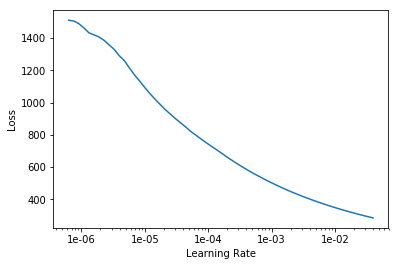

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
for i, m in enumerate(find_modules(model, is_conv_layer)): 
    print(f'\n\nLayer {i}')
    print(lsuv_conv(m, xb[0], model))



Layer 0
(tensor(0.0479), tensor(1.0000))


Layer 1
(tensor(0.1595), tensor(1.))


Layer 2
(tensor(0.1082), tensor(1.0000))


Layer 3
(tensor(-0.0518), tensor(1.0000))


Layer 4
(tensor(0.0957), tensor(1.0000))


Layer 5
(tensor(-0.2340), tensor(1.0000))


Layer 6
(tensor(0.1111), tensor(1.))


Layer 7
(tensor(-0.4350), tensor(1.0000))


Layer 8
(tensor(0.0743), tensor(1.))


Layer 9
(tensor(-0.5571), tensor(1.))


Layer 10
(tensor(0.0200), tensor(1.0000))


Layer 11
(tensor(-0.6230), tensor(1.0000))


Layer 12
(tensor(0.0449), tensor(1.))


Layer 13
(tensor(-0.6435), tensor(1.))


Layer 14
(tensor(0.0567), tensor(1.0000))


Layer 15
(tensor(-0.9325), tensor(1.0000))


Layer 16
(tensor(-0.0202), tensor(1.0000))


Layer 17
(tensor(-0.9684), tensor(1.))


Layer 18
(tensor(-0.1152), tensor(1.0000))


Layer 19
(tensor(-1.2261), tensor(1.0000))


Layer 20
(tensor(-0.1203), tensor(1.))


Layer 21
(tensor(-1.2144), tensor(1.0000))


Layer 22
(tensor(-0.1511), tensor(1.0000))


Layer 23
(tens

In [37]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.1483)] / [tensor(1.0661)]

ConvLayer: 
[tensor(0.2559)] / [tensor(1.1170)]

ConvLayer: 
[tensor(0.2146)] / [tensor(1.1115)]

ConvLayer: 
[tensor(0.1286)] / [tensor(1.2927)]

ConvLayer: 
[tensor(0.3399)] / [tensor(1.3455)]

ConvLayer: 
[tensor(-0.0165)] / [tensor(1.9630)]

ConvLayer: 
[tensor(0.0916)] / [tensor(2.5217)]

ConvLayer: 
[tensor(-0.0217)] / [tensor(1.3233)]

ConvLayer: 
[tensor(0.3127)] / [tensor(1.3378)]

ConvLayer: 
[tensor(0.0022)] / [tensor(1.9162)]

ConvLayer: 
[tensor(-0.2644)] / [tensor(1.2933)]

ConvLayer: 
[tensor(0.2018)] / [tensor(1.2378)]

ConvLayer: 
[tensor(0.0398)] / [tensor(1.7736)]

ConvLayer: 
[tensor(-0.3800)] / [tensor(1.3095)]

ConvLayer: 
[tensor(0.1656)] / [tensor(1.2296)]

ConvLayer: 
[tensor(-0.0407)] / [tensor(1.7410)]

ConvLayer: 
[tensor(-0.1142)] / [tensor(4.5203)]

ConvLayer: 
[tensor(-0.4142)] / [tensor(1.3431)]

ConvLayer: 
[tensor(0.2121)] / [tensor(1.2326)]

ConvLayer: 
[tensor(0.0251)] / [tensor(1.7428)]

ConvLayer: 
[

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


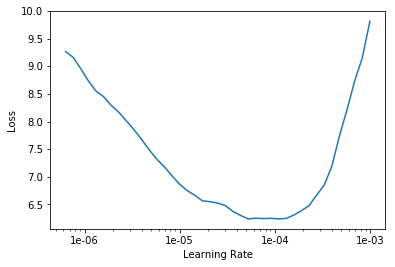

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,2.038561,1.913743,0.384000,00:24
1,2.204992,2.388573,0.342000,00:24
2,1.883617,1.628003,0.524000,00:24
3,1.641687,1.403267,0.544000,00:24
4,1.407786,1.218647,0.620000,00:24
5,1.268107,1.168021,0.634000,00:24
6,1.136081,1.088062,0.672000,00:24
7,1.031793,0.926545,0.690000,00:24
8,0.920830,0.829313,0.742000,00:24
9,0.894791,0.831985,0.726000,00:24


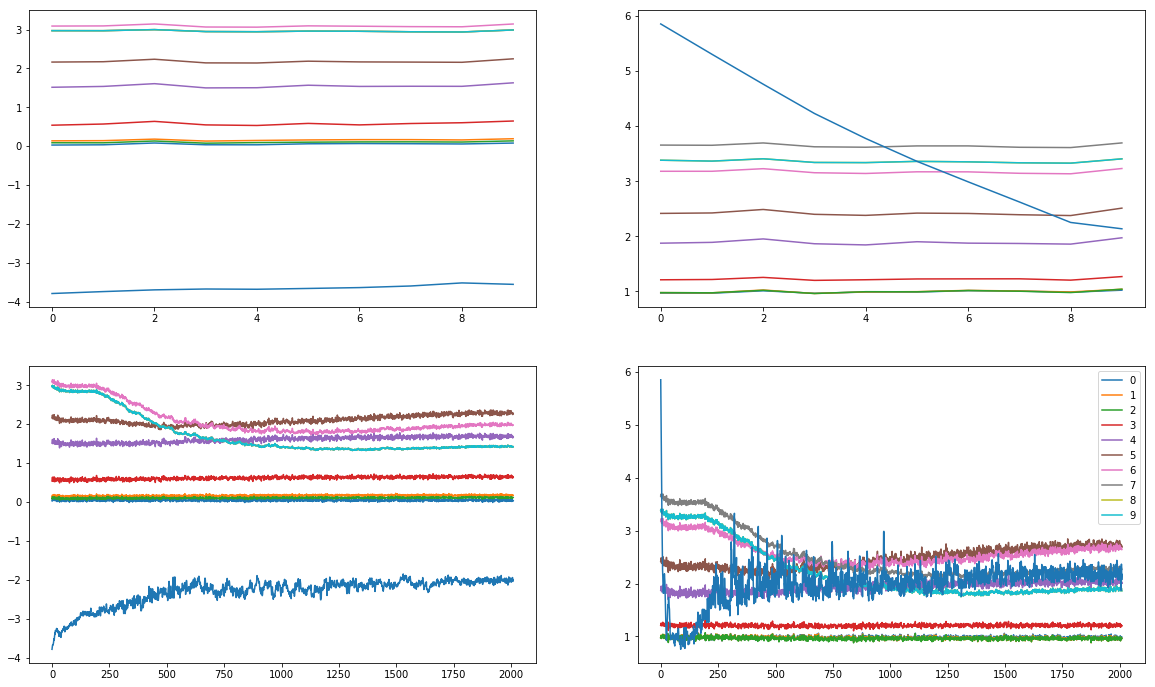

In [40]:
recorder.add_exp(learn.recorder, "LSUV init")
viz(hooks)

In [41]:
if HIST:
    stats_ratio_zeros(hooks)

# Results

In [42]:
recorder.plot_results_plotly(NB_EPOCHS, True)

In [43]:
activations_prestats

[[([tensor(0.2139)], [tensor(0.3946)]),
  ([tensor(0.0804)], [tensor(0.1414)]),
  ([tensor(0.0334)], [tensor(0.0544)]),
  ([tensor(0.0156)], [tensor(0.0290)]),
  ([tensor(0.0075)], [tensor(0.0114)]),
  ([tensor(-0.0002)], [tensor(0.0078)]),
  ([tensor(-0.0022)], [tensor(0.0503)]),
  ([tensor(0.0069)], [tensor(0.0121)]),
  ([tensor(0.0032)], [tensor(0.0047)]),
  ([tensor(-0.0002)], [tensor(0.0032)]),
  ([tensor(0.0071)], [tensor(0.0113)]),
  ([tensor(0.0029)], [tensor(0.0047)]),
  ([tensor(-3.9017e-05)], [tensor(0.0032)]),
  ([tensor(0.0077)], [tensor(0.0118)]),
  ([tensor(0.0032)], [tensor(0.0050)]),
  ([tensor(-2.7087e-05)], [tensor(0.0035)]),
  ([tensor(-0.0005)], [tensor(0.0188)]),
  ([tensor(0.0026)], [tensor(0.0044)]),
  ([tensor(0.0011)], [tensor(0.0016)]),
  ([tensor(2.4878e-05)], [tensor(0.0012)]),
  ([tensor(0.0034)], [tensor(0.0049)]),
  ([tensor(0.0011)], [tensor(0.0019)]),
  ([tensor(-5.3007e-05)], [tensor(0.0013)]),
  ([tensor(0.0026)], [tensor(0.0047)]),
  ([tensor(0.0010

In [44]:
x = range(len(activations_prestats[0]))

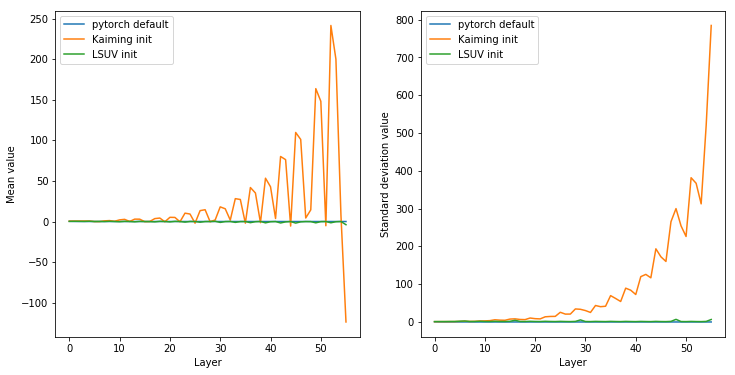

In [45]:
mean_prestat = []
std_prestat = []
for exp in activations_prestats:
    exp = np.array(exp)
    mean_prestat.append(exp[:, 0])
    std_prestat.append(exp[:, 1])


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.set_xlabel('Layer')
ax1.set_ylabel('Mean value')

ax2.set_xlabel('Layer')
ax2.set_ylabel('Standard deviation value')
for i, m in enumerate(mean_prestat):
    ax1.plot(x, m, label=recorder.labels[i])
for i, s in enumerate(std_prestat):
    ax2.plot(x, s, label=recorder.labels[i])
    
ax1.legend()    
ax2.legend()

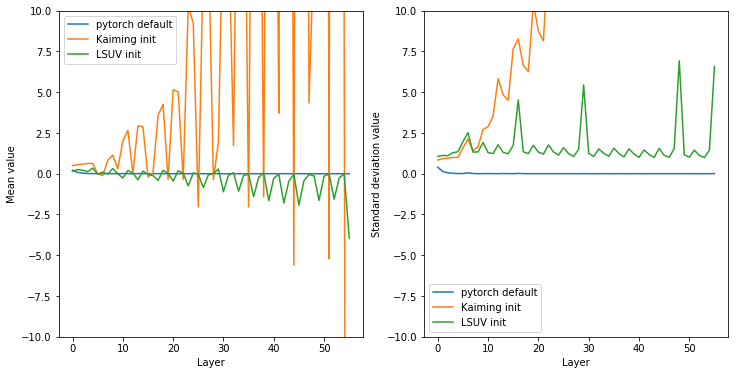

In [46]:
mean_prestat = []
std_prestat = []
for exp in activations_prestats:
    exp = np.array(exp)
    mean_prestat.append(exp[:, 0])
    std_prestat.append(exp[:, 1])


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.set_xlabel('Layer')
ax1.set_ylabel('Mean value')

ax2.set_xlabel('Layer')
ax2.set_ylabel('Standard deviation value')
for i, m in enumerate(mean_prestat):
    ax1.plot(x, m, label=recorder.labels[i])
for i, s in enumerate(std_prestat):
    ax2.plot(x, s, label=recorder.labels[i])

ax1.set_ylim([-10,10])   
ax2.set_ylim([-10,10]) 
ax1.legend()    
ax2.legend()